In [14]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from re import VERBOSE

# Create an ImageDataGenerator for rescaling the images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and test data into numpy arrays
train_generator = train_datagen.flow_from_directory(
    'skin_cancer_dataset/skin_cancer_dataset/Train',
    target_size=(64, 64),
    batch_size=32,
    class_mode=None,  # No labels needed for autoencoder
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    'skin_cancer_dataset/skin_cancer_dataset/Test',
    target_size=(64, 64),
    batch_size=32,
    class_mode=None  # No labels needed for autoencoder
)

# Define a custom generator for the autoencoder
def autoencoder_generator(generator):
    for batch in generator:
        yield (batch, batch)  # Input and output are the same for autoencoder

# Define the autoencoder model with Dropout layers to avoid overfitting
input_img = Input(shape=(64, 64, 3))  # Input shape of the images

# Define the encoder with Batch Normalization
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.5)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.5)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  # Output shape is (8, 8, 128)

# Define the decoder with Batch Normalization
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Now output shape becomes (16, 16, 64)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Now output shape becomes (32, 32, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Now output shape becomes (64, 64, 32)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Final output should match (64, 64, 3)

# Combine encoder and decoder into an autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


# Get the number of samples in the dataset
train_samples = train_generator.n
test_samples = test_generator.n

# Calculate steps per epoch
steps_per_epoch_train = train_samples // 32  # Batch size of 32
steps_per_epoch_test = test_samples // 32

# Early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=15, mode='max', restore_best_weights=True)

# ModelCheckpoint with .keras extension
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', save_best_only=True, monitor='val_loss', mode='max')

# ReduceLROnPlateau callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_sheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Train the autoencoder using the custom generator
autoencoder.fit(
    autoencoder_generator(train_generator),
    steps_per_epoch=steps_per_epoch_train,
    epochs=50,
    validation_data=autoencoder_generator(test_generator),
    validation_steps=steps_per_epoch_test,
    callbacks=[early_stopping, model_checkpoint, lr_sheduler]
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.
Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 28s 357ms/step - loss: 0.0331 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 22s 316ms/step - loss: 0.0068 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 49s 725ms/step - loss: 0.0045 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 54s 777ms/step - loss: 0.0042 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 53s 763ms/step - loss: 0.0032 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 54s 786ms/step - loss: 0.0036 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 54s 786ms/step - loss: 0.0033 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 53s 774ms/step - loss: 0.0031 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 9/50
69/69 ━━━━━━━━━━━━

## **Autoencoder for Feature Extraction + CNN for Classification**

Step 1: Extract Encoded Features Using the Encoder
Since we already trained our autoencoder, we can now extract the encoder part of the autoencoder to obtain the compressed features of our images.

Create the Encoder: We will extract the encoder from the autoencoder and use it to generate compressed representations of our images.

In [15]:
# Define a custom generator for prediction that only yields input data
def predict_generator(generator):
    for batch in generator:
        yield (batch, batch)  # The model expects (input, target), so we return (batch, batch) for autoencoders

# Extract the encoder from the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=5).output)  # Layer before decoding starts

# Generate encoded (compressed) features for training and test data
encoded_train = encoder.predict(predict_generator(train_generator), steps=steps_per_epoch_train)
encoded_test = encoder.predict(predict_generator(test_generator), steps=steps_per_epoch_test)

print(f'Encoded train data shape: {encoded_train.shape}')
print(f'Encoded test data shape: {encoded_test.shape}')


69/69 ━━━━━━━━━━━━━━━━━━━━ 44s 638ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step 
Encoded train data shape: (2207, 32, 32, 64)
Encoded test data shape: (86, 32, 32, 64)


The encoder.predict() function will generate the lower-dimensional representations (encoded features) of the input images.

Step 2: Define the CNN for Classification
Now that we have the encoded features, we will use them as input to a CNN classifier. The CNN will be responsible for classifying the compressed representations into their respective categories (e.g., the nine classes).

Define the CNN: we can now define a CNN that takes the encoded features as input.

In [16]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

# Define the CNN model for classification (using fully connected layers)
cnn_model = Sequential()

# Input layer
cnn_model.add(Input(shape=encoded_train.shape[1:]))  # Using Input layer explicitly

# Fully connected layers (Increase the number of layers and nodes)
cnn_model.add(Flatten())  # Flatten the encoded inputs

cnn_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001))) 
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))  
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

# Output layer for 9 classes (using softmax for multi-class classification)
cnn_model.add(Dense(9, activation='softmax'))  # 9 classes

# Define the Adam optimizer with the learning rate
adam_optimizer = Adam(learning_rate=0.0001)  # Increased learning rate

# Compile the CNN model with the optimizer
cnn_model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(cnn_model.summary())


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,731,849 (128.68 MB)

 Trainable params: 33,729,929 (128.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

None


Note: The final layer uses a softmax activation because we are performing multi-class classification (9 classes in this case).
Step 3: Prepare the Labels for Classification
we need to retrieve the labels from the original data and convert them to one-hot encoded format because we’ll be performing multi-class classification.

In [17]:
from tensorflow.keras.utils import to_categorical

# Load the original labels from train and test generators
train_labels = train_generator.classes  # The labels for the training data
test_labels = test_generator.classes  # The labels for the test data

# Convert the labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels, num_classes=9)  # 9 classes
test_labels_one_hot = to_categorical(test_labels, num_classes=9)


Step 4: Train the CNN Using the Encoded Features
Now that we have the encoded features and their corresponding labels, we can train the CNN model.

In [18]:
print(f'Encoded test shape: {encoded_test.shape}')  # Shape of encoded test data
print(f'Test labels shape: {test_labels_one_hot.shape}')  # Shape of test labels


Encoded test shape: (86, 32, 32, 64)
Test labels shape: (118, 9)


In [19]:
# Trim the test labels to match the size of the encoded test data
test_labels_one_hot = test_labels_one_hot[:96]

# Verify the new shapes
print(f'Updated encoded test shape: {encoded_test.shape}')
print(f'Updated test labels shape: {test_labels_one_hot.shape}')


Updated encoded test shape: (86, 32, 32, 64)
Updated test labels shape: (96, 9)


Updated encoded train shape: (2207, 32, 32, 64)
Updated train labels shape: (2207, 9)
Updated encoded test shape: (86, 32, 32, 64)
Updated test labels shape: (86, 9)
Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 384ms/step - accuracy: 0.0975 - loss: 4.9363 - val_accuracy: 0.2209 - val_loss: 3.2336 - learning_rate: 1.0000e-04
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 330ms/step - accuracy: 0.1100 - loss: 4.4813 - val_accuracy: 0.0465 - val_loss: 3.7070 - learning_rate: 1.0000e-04
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 328ms/step - accuracy: 0.1142 - loss: 4.5771 - val_accuracy: 0.1163 - val_loss: 3.6251 - learning_rate: 1.0000e-04
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 327ms/step - accuracy: 0.1018 - loss: 4.2905 - val_accuracy: 0.1163 - val_loss: 3.3357 - learning_rate: 1.0000e-04
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 326ms/step - accuracy: 0.1208 - loss: 4.3229 - val_accuracy: 0.1628 - val_loss: 3.6075 - learning_rate: 1.0000e-04
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 32

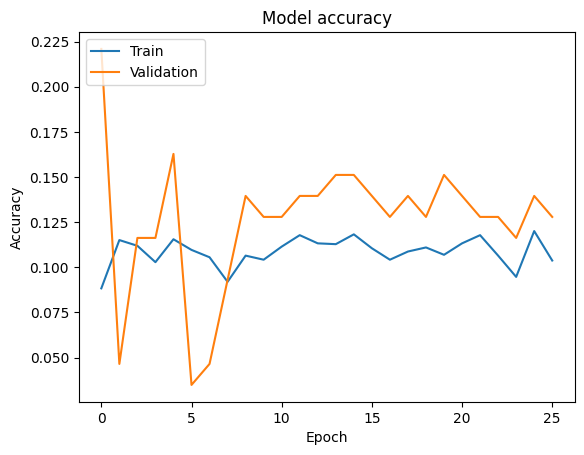

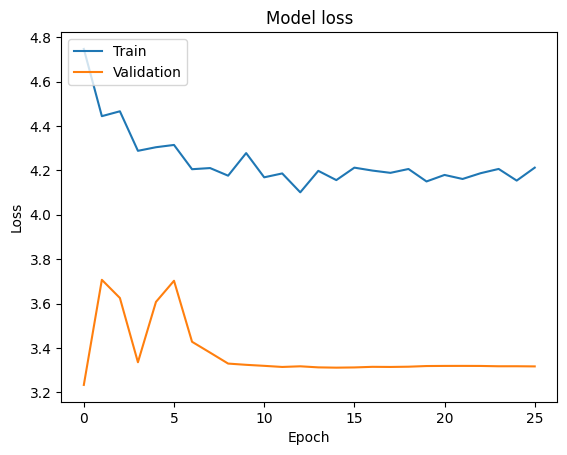

In [20]:
# Trim the training labels to match the size of the encoded training data
train_labels_one_hot = train_labels_one_hot[:encoded_train.shape[0]]

# Similarly, check and trim the test set if needed
test_labels_one_hot = test_labels_one_hot[:encoded_test.shape[0]]

# Verify the new shapes
print(f'Updated encoded train shape: {encoded_train.shape}')
print(f'Updated train labels shape: {train_labels_one_hot.shape}')
print(f'Updated encoded test shape: {encoded_test.shape}')
print(f'Updated test labels shape: {test_labels_one_hot.shape}')

# Compute class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Use balanced class weight
    classes=np.unique(np.argmax(train_labels_one_hot, axis=1)),  # Unique class labels
    y=np.argmax(train_labels_one_hot, axis=1)  # Actual class labels
)

# Convert the class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max')

# ModelCheckpoint with .keras extension
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# ReduceLROnPlateau callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_sheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Train the CNN model
history = cnn_model.fit(
    encoded_train, train_labels_one_hot,
    epochs=100,
    batch_size=32,
    validation_data=(encoded_test, test_labels_one_hot),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, lr_sheduler]
)

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(encoded_test, test_labels_one_hot)
accuracy_percentage = test_accuracy
print(f'Test Accuracy: {accuracy_percentage}%')

# Plotting Accuracy and Loss
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

This will train our CNN classifier on the encoded features extracted by the autoencoder.

Step 5: Evaluate the CNN Model
After training, we can evaluate the CNN on the test set to check its accuracy.


Step 6: Save the Model
Finally, we can save both the autoencoder and CNN models for future use.

In [21]:
# Save the CNN model
cnn_model.save('cnn_classification_model.h5')

# Optionally, save the encoder if you want to reuse it
encoder.save('encoder_model.h5')